In [1]:
pip install opencv-contrib-python 

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Using PyTorch version 2.2.1+cu121


device(type='cuda')

In [7]:
transform= transforms.ToTensor()

In [8]:
metadata = pd.read_csv('ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
df['target'] = df[['MEL', 'NV', 'BCC', 'AK', 'DF', 'VASC', 'SCC', 'UNK']].sum(axis=1) # 1 for Malignant || 0 for Benign
diagnosis_map = {0: 'benign', 1: 'malignant'}
df['diagnosis'] = df['target'].map(diagnosis_map)
data = df.loc[:, ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']]
data['image'] = 'autodl-tmp/ISIC_2019_Training_Input/' + data['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,55.0,anterior torso,female,1.0,malignant
1,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,anterior torso,female,1.0,malignant
2,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,60.0,upper extremity,female,1.0,malignant
3,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,upper extremity,male,1.0,malignant
4,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,80.0,posterior torso,male,1.0,malignant
...,...,...,...,...,...,...
25326,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
25327,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
25328,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
25329,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


In [9]:
isic_data = pd.read_csv('train.csv').drop(['patient_id', 'diagnosis'],axis=1)

# Selecting specific columns using .loc[]
isic_Data = isic_data.loc[:, ['image_name', 'age_approx', 'anatom_site_general_challenge', 'sex', 'target', 'benign_malignant']]
isic_data = isic_data.rename(columns={
    'image_name' : 'image',
    'anatom_site_general_challenge': 'anatom_site_general',
    'benign_malignant': 'diagnosis',
})

column_order = ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']

isic_data = isic_data[column_order]

# Update the image column with the path to the image
isic_data['image'] = 'autodl-tmp/jpeg/train/' + isic_data['image'] + '.jpg'
isic_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0,benign
...,...,...,...,...,...,...
33121,autodl-tmp/jpeg/train/ISIC_9999134.jpg,50.0,torso,male,0,benign
33122,autodl-tmp/jpeg/train/ISIC_9999320.jpg,65.0,torso,male,0,benign
33123,autodl-tmp/jpeg/train/ISIC_9999515.jpg,20.0,lower extremity,male,0,benign
33124,autodl-tmp/jpeg/train/ISIC_9999666.jpg,50.0,lower extremity,male,0,benign


In [10]:
# Concatenating the two DataFrames
combined_data = pd.concat([isic_data, data], ignore_index=True).reset_index(drop=True)

combined_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0.0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0.0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0.0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0.0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0.0,benign
...,...,...,...,...,...,...
58452,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
58453,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
58454,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
58455,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


,Feature Name,Number of Nulls
0,image,0
1,age_approx,505
2,anatom_site_general,3158
3,sex,449
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58457 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                58457 non-null  object 
 1   age_approx           57952 non-null  float64
 2   anatom_site_general  55299 non-null  object 
 3   sex                  58008 non-null  object 
 4   target               58457 non-null  float64
 5   diagnosis            58457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.7+ MB
None


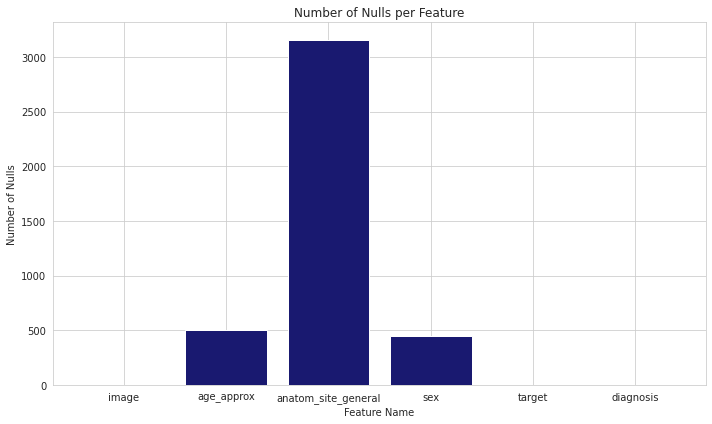

,Feature Name,Number of Nulls
0,image,0
1,age_approx,0
2,anatom_site_general,0
3,sex,0
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
Index: 55011 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                55011 non-null  object 
 1   age_approx           55011 non-null  float64
 2   anatom_site_general  55011 non-null  object 
 3   sex                  55011 non-null  object 
 4   target               55011 non-null  float64
 5   diagnosis            55011 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.9+ MB
None


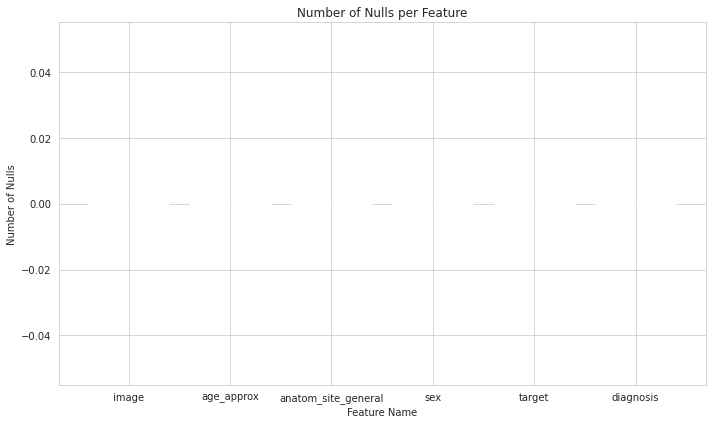

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
def null_analysis(data):
    df_null_info = pd.DataFrame(columns=['Feature Name', 'Number of Nulls'])
    for data_label in data.columns.tolist():
        num_nulls = data[data_label].isnull().sum()
        df_null_info = pd.concat([df_null_info, pd.DataFrame({'Feature Name': [data_label], 'Number of Nulls': [num_nulls]})], ignore_index=True)
    display(df_null_info)
    print(data.info())

    plt.figure(figsize=(10, 6))
    plt.bar(df_null_info['Feature Name'], df_null_info['Number of Nulls'], color='midnightblue')
    plt.xlabel('Feature Name')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls per Feature')

    # Show the plot
    plt.tight_layout()
    plt.show()

null_analysis(combined_data)
combined_data = combined_data.dropna()
null_analysis(combined_data)

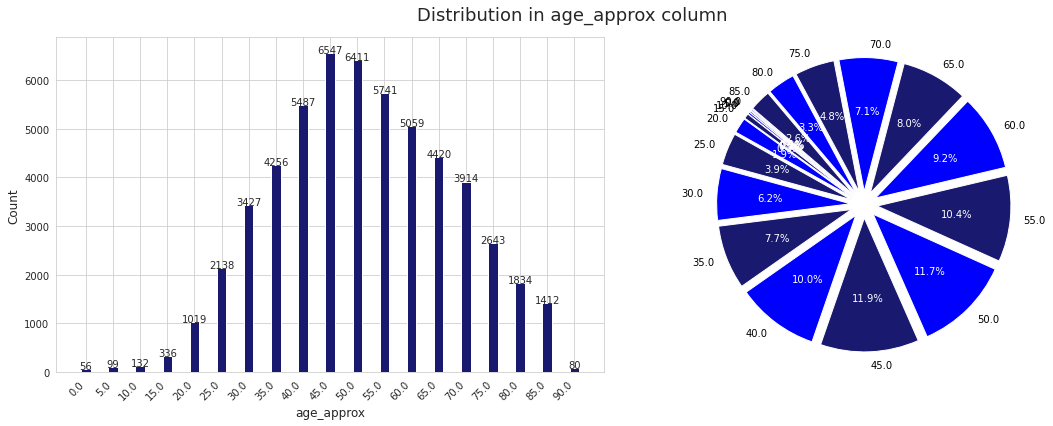

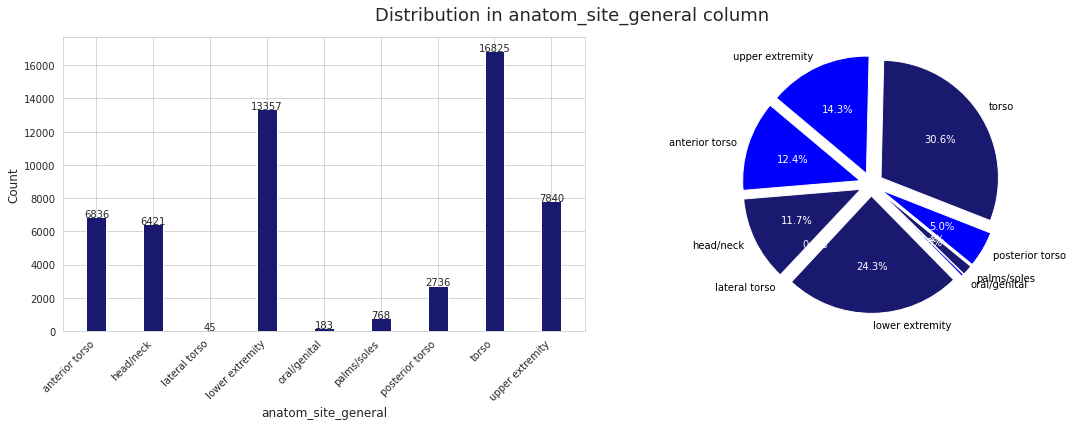

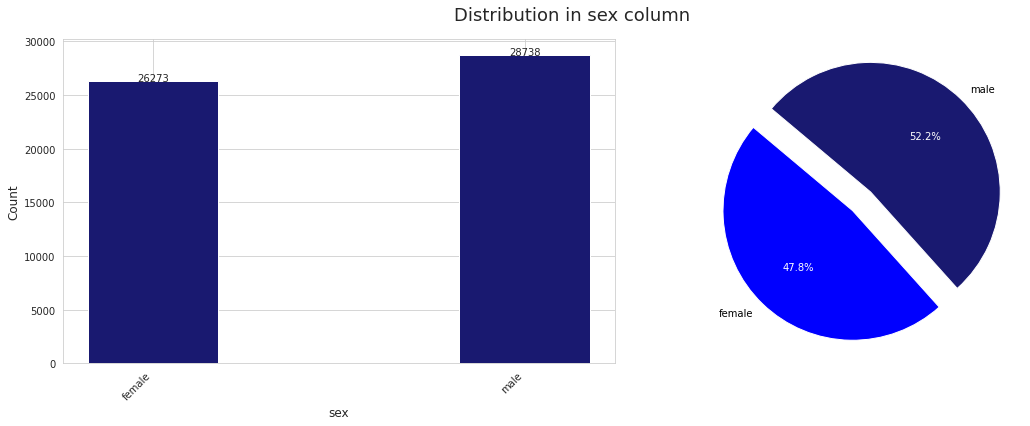

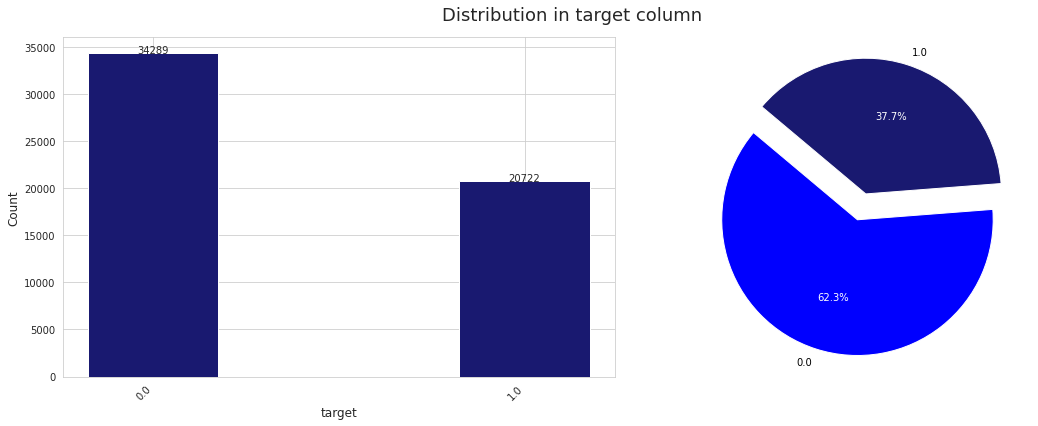

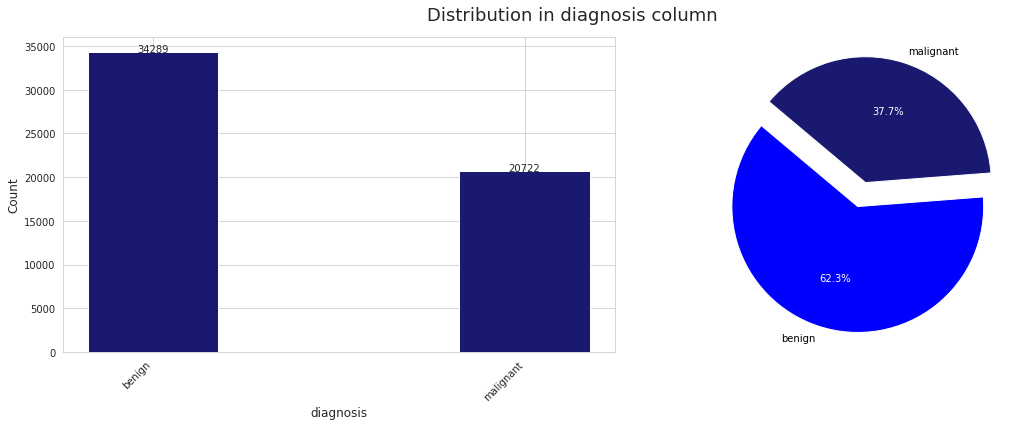

In [12]:
def plot_distribution(dataframe, target_column):
    # Calculate value counts and sort them
    value_counts = dataframe[target_column].value_counts().sort_index()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar plot on the first subplot
    bar_width = 0.35
    ind = np.arange(len(value_counts))
    rects = ax1.bar(ind, value_counts.values, width=bar_width, color='midnightblue')
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)

    # Add values on top of bars
    for index, value in enumerate(value_counts.values):
        ax1.text(index, value + 0.1, str(value), ha='center', fontsize=10)

    # Pie plot 
    explode = [0.1 for i in range(len(value_counts))]
    patches, texts, autotexts = ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=["blue","midnightblue"], explode=explode, startangle=140)

    # Adjust the distance of the labels from the center
    for text in texts:
        text.set_color('black')
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
    # Main title for the figure
    fig.suptitle(f'Distribution in {target_column} column', fontsize=18)
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()
    
for column in data.columns:
    if column == 'image':
        continue
    plot_distribution(combined_data, column)

In [13]:
labelencoder= LabelEncoder() 
combined_data['anatom_site_general_encoded'] = labelencoder.fit_transform(combined_data['anatom_site_general']) 
combined_data['sex_encoded'] = labelencoder.fit_transform(combined_data['sex']) 
combined_data['diagnosis_encoded'] = labelencoder.fit_transform(combined_data['diagnosis'])
combined_data_NoC=combined_data.drop(['anatom_site_general', 'sex', 'diagnosis'], axis=1)
# scale the age
scaler = MinMaxScaler()
combined_data_NoC['age_approx'] = scaler.fit_transform( combined_data_NoC['age_approx'].values.reshape(-1, 1))

combined_data_NoC.head()

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,0.500000,0.0,1,1,0
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,0.500000,0.0,8,0,0
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,0.555556,0.0,3,0,0
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,0.500000,0.0,1,0,0
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,0.611111,0.0,8,0,0


In [14]:
train_data, test_data = train_test_split(combined_data_NoC, test_size=0.3, stratify=combined_data_NoC['target'], random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['target'], random_state=42)

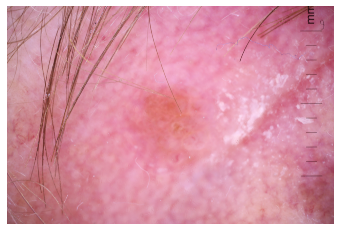

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
34258,autodl-tmp/ISIC_2019_Training_Input/ISIC_00111...,0.666667,1.0,3,0,1
10846,autodl-tmp/jpeg/train/ISIC_3349562.jpg,0.222222,0.0,3,1,0
51270,autodl-tmp/ISIC_2019_Training_Input/ISIC_00618...,0.833333,0.0,0,0,0
46910,autodl-tmp/ISIC_2019_Training_Input/ISIC_00548...,0.833333,1.0,0,1,1
38073,autodl-tmp/ISIC_2019_Training_Input/ISIC_00263...,0.333333,1.0,6,0,1
...,...,...,...,...,...,...
37494,autodl-tmp/ISIC_2019_Training_Input/ISIC_00257...,0.388889,1.0,3,0,1
1602,autodl-tmp/jpeg/train/ISIC_0584566.jpg,0.444444,0.0,8,1,0
803,autodl-tmp/jpeg/train/ISIC_0343957.jpg,0.444444,0.0,8,0,0
29621,autodl-tmp/jpeg/train/ISIC_8961663.jpg,0.944444,0.0,7,0,0


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image you want to display
image_path = 'autodl-tmp/jpeg/train/ISIC_2637011.jpg'

# Open the image using PI
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure()
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()

train_data

In [16]:
valid_data

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
13457,autodl-tmp/jpeg/train/ISIC_4131810.jpg,0.333333,0.0,1,1,0
27086,autodl-tmp/jpeg/train/ISIC_8204544.jpg,0.611111,0.0,3,0,0
32110,autodl-tmp/jpeg/train/ISIC_9699087.jpg,0.777778,0.0,7,1,0
3529,autodl-tmp/jpeg/train/ISIC_1165548.jpg,0.444444,0.0,3,1,0
50525,autodl-tmp/ISIC_2019_Training_Input/ISIC_00606...,0.888889,1.0,1,1,1
...,...,...,...,...,...,...
9422,autodl-tmp/jpeg/train/ISIC_2922270.jpg,0.388889,0.0,3,1,0
36903,autodl-tmp/ISIC_2019_Training_Input/ISIC_00251...,0.388889,0.0,0,0,0
53567,autodl-tmp/ISIC_2019_Training_Input/ISIC_00655...,0.833333,1.0,0,1,1
26310,autodl-tmp/jpeg/train/ISIC_7984569.jpg,0.555556,0.0,7,0,0


In [17]:
test_data

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
32378,autodl-tmp/jpeg/train/ISIC_9777543.jpg,0.666667,0.0,7,1,0
51854,autodl-tmp/ISIC_2019_Training_Input/ISIC_00627...,0.444444,1.0,1,0,1
39808,autodl-tmp/ISIC_2019_Training_Input/ISIC_00280...,0.555556,1.0,0,0,1
45433,autodl-tmp/ISIC_2019_Training_Input/ISIC_00337...,0.944444,1.0,8,1,1
2815,autodl-tmp/jpeg/train/ISIC_0941332.jpg,1.000000,0.0,7,0,0
...,...,...,...,...,...,...
7113,autodl-tmp/jpeg/train/ISIC_2222489.jpg,0.500000,0.0,5,1,0
42604,autodl-tmp/ISIC_2019_Training_Input/ISIC_00308...,0.611111,1.0,0,1,1
2785,autodl-tmp/jpeg/train/ISIC_0931725.jpg,1.000000,0.0,7,0,0
15618,autodl-tmp/jpeg/train/ISIC_4772294.jpg,0.555556,0.0,3,0,0


In [18]:
'''class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        age = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32).to(device)
        anatom_site = torch.tensor(self.dataframe.iloc[idx, 3], dtype=torch.float32).to(device)
        sex = torch.tensor(self.dataframe.iloc[idx, 4], dtype=torch.float32).to(device)
        label = torch.tensor(self.dataframe.iloc[idx, 5], dtype=torch.long).to(device)

        if self.transform:
            image = self.transform(image)

        return image.to(device), age, anatom_site, sex, label'''

'class CustomDataset(Dataset):\n    def __init__(self, dataframe, transform=None):\n        self.dataframe = dataframe\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.dataframe)\n\n    def __getitem__(self, idx):\n        img_name = self.dataframe.iloc[idx, 0]\n        image = Image.open(img_name)\n\n        age = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32).to(device)\n        anatom_site = torch.tensor(self.dataframe.iloc[idx, 3], dtype=torch.float32).to(device)\n        sex = torch.tensor(self.dataframe.iloc[idx, 4], dtype=torch.float32).to(device)\n        label = torch.tensor(self.dataframe.iloc[idx, 5], dtype=torch.long).to(device)\n\n        if self.transform:\n            image = self.transform(image)\n\n        return image.to(device), age, anatom_site, sex, label'

In [19]:
from torch.utils.data import DataLoader
from torchvision import transforms
from custom_dataset import CustomDataset
import matplotlib.pyplot as plt
import pandas as pd
import torch
import multiprocessing

# Set multiprocessing start method
multiprocessing.set_start_method('spawn', force=True)

# Define your transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

# Assuming you have your train_data, valid_data, and test_data DataFrame defined
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)

# Define dataset and dataloaders for train and test sets with num_workers
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

print('Data loading and preprocessing completed.')

Data loading and preprocessing completed.


In [20]:
'''train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)

valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Define dataset and dataloaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print('Data loading and preprocessing completed.')
'''

"train_transform = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomRotation(degrees=30),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),\n    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),\n    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),\n    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),\n    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),\n    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),\n    transforms.ToTensor(),  \n])\n\n# Define transforms for the data (adjust as necessary)\ntest_transform = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(), \n])\n\n# Define dataset and dataloaders for train and test sets\ntrain_dataset = CustomDataset(train_data,

In [21]:
# Get one batch
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = batch
    break


terminate called without an active exception
terminate called without an active exception


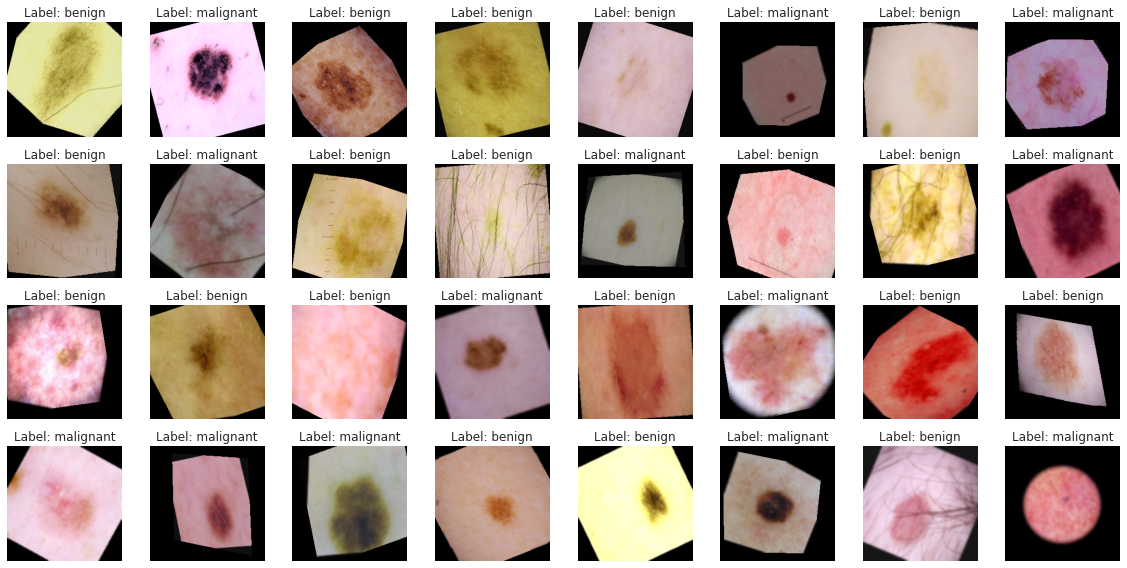

In [22]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {diagnosis_map[int(labels[i])]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()

In [23]:
# Get one batch
for batch in valid_loader:
    images, ages, anatom_sites, sexs, labels = batch
    break


terminate called without an active exception
terminate called without an active exception
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d7b6fac10>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/root/miniconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/root/miniconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/root/miniconda3/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self.

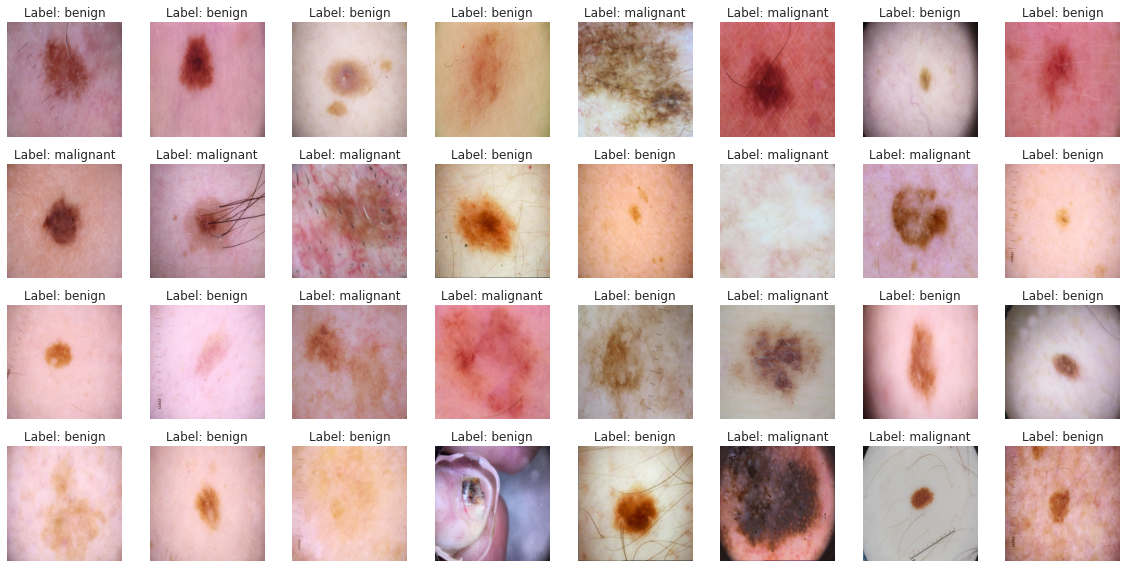

In [24]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {diagnosis_map[int(labels[i])]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()

In [25]:
# Get one batch
for batch in test_loader:
    images, ages, anatom_sites, sexs, labels = batch
    break

terminate called without an active exception
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1d7b6fac10>
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/root/miniconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/root/miniconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/root/miniconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/root/miniconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/root/miniconda3/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
  File "/root/minicon

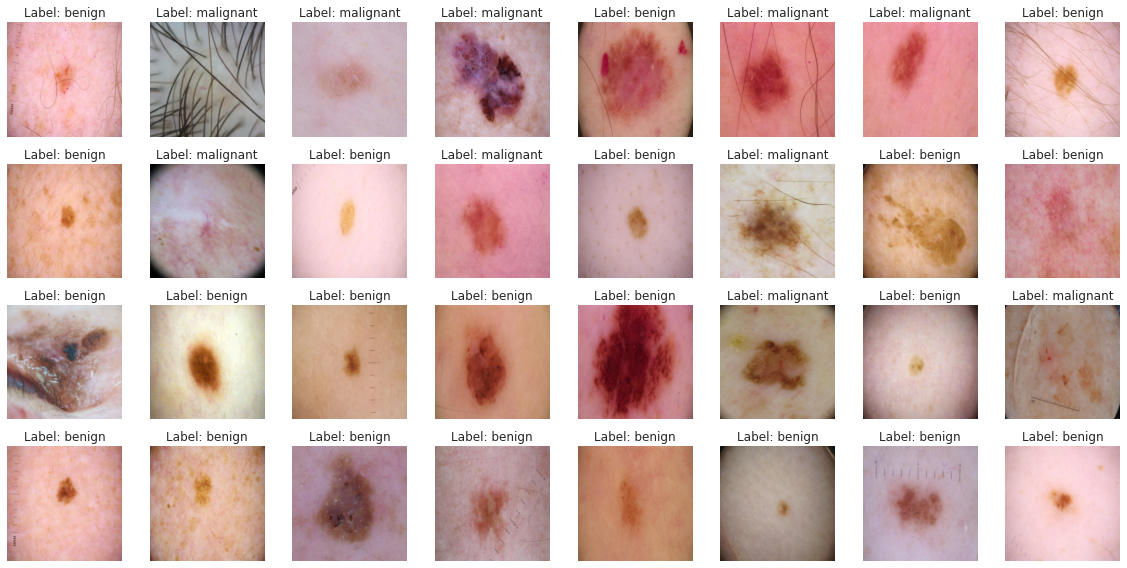

In [26]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {diagnosis_map[int(labels[i])]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()

In [27]:

import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
 
 
__all__ = ['ResNet', 'resnet18_cbam', 'resnet34_cbam', 'resnet50_cbam', 'resnet101_cbam',
           'resnet152_cbam']
 
 
model_urls = {
    'resnet18': 'resnet_model.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}
 
 
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
 
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=False),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
 
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
 
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
 
class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
 
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
 
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        out = self.ca(out) * out
        out = self.sa(out) * out
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
 
 
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
 
        self.ca = ChannelAttention(planes * 4)
        self.sa = SpatialAttention()
 
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        out = self.ca(out) * out
        out = self.sa(out) * out
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
 
 
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x
 
 
def resnet18_cbam(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_state_dict = model_zoo.load_url(model_urls['resnet18'])
        now_state_dict        = model.state_dict()
        now_state_dict.update(pretrained_state_dict)
        model.load_state_dict(now_state_dict)
    return model

  

'\nimport torch\nimport torch.nn as nn\nimport math\nimport torch.utils.model_zoo as model_zoo\n \n \n__all__ = [\'ResNet\', \'resnet18_cbam\', \'resnet34_cbam\', \'resnet50_cbam\', \'resnet101_cbam\',\n           \'resnet152_cbam\']\n \n \nmodel_urls = {\n    \'resnet18\': \'resnet_model.pth\',\n    \'resnet34\': \'https://download.pytorch.org/models/resnet34-333f7ec4.pth\',\n    \'resnet50\': \'https://download.pytorch.org/models/resnet50-19c8e357.pth\',\n    \'resnet101\': \'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth\',\n    \'resnet152\': \'https://download.pytorch.org/models/resnet152-b121ed2d.pth\',\n}\n \n \ndef conv3x3(in_planes, out_planes, stride=1):\n    "3x3 convolution with padding"\n    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,\n                     padding=1, bias=False)\n \nclass ChannelAttention(nn.Module):\n    def __init__(self, in_planes, ratio=16):\n        super(ChannelAttention, self).__init__()\n        self.avg_pool =

In [28]:
#resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
#from resnet_cbam.py import resnet18_cbam 
# 创建模型  
resnet18_cbam = resnet18_cbam(pretrained=False).to(device)  # 将模型移动到适当的设备（GPU或CPU）
print(resnet18_cbam)
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = [item.to(device) for item in batch]
    break


'#resnet18 = torchvision.models.resnet18(pretrained=True).to(device)\n#from resnet_cbam.py import resnet18_cbam \n# 创建模型  \nresnet18_cbam = resnet18_cbam(pretrained=False).to(device)  # 将模型移动到适当的设备（GPU或CPU）\nprint(resnet18_cbam)\nfor batch in train_loader:\n    images, ages, anatom_sites, sexs, labels = [item.to(device) for item in batch]\n    break\n'

In [29]:
resnet18_cbam.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18_cbam.parameters(), lr=3e-5)
resnet18_cbam = resnet18_cbam.to(device)


'resnet18_cbam.fc = torch.nn.Linear(in_features=512, out_features=2)\nloss_fn = torch.nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(resnet18_cbam.parameters(), lr=3e-5)\nresnet18_cbam = resnet18_cbam.to(device)\n'

In [30]:
display(train_loader)
# Training the model
display(valid_loader)
display(test_loader)
model = resnet18_cbam
criterion = nn.CrossEntropyLoss()
from sklearn.metrics import roc_auc_score

def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 

epochs = 6
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")


'display(train_loader)\n# Training the model\ndisplay(valid_loader)\ndisplay(test_loader)\nmodel = resnet18_cbam\ncriterion = nn.CrossEntropyLoss()\nfrom sklearn.metrics import roc_auc_score\n\ndef validate_model(model, val_loader, criterion, device):  \n    model.eval()  # 设置为评估模式  \n    val_loss = 0.0  \n    correct = 0  \n    total = 0  \n    with torch.no_grad():  # 不需要计算梯度  \n        for data in tqdm(val_loader, desc="Validation"):  \n            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  \n            outputs = model(inputs)  \n            loss = criterion(outputs, labels)  \n            val_loss += loss.item()  \n            _, predicted = torch.max(outputs, 1)  \n            total += labels.size(0)  \n            correct += (predicted == labels).sum().item()  \n    val_loss /= len(val_loader)  \n    val_accuracy = correct / total  \n    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  \n    return val_loss, val_accurac

In [31]:

torch.save(model.state_dict(), 'resnet_cbam_model.pth')


"\ntorch.save(model.state_dict(), 'resnet_cbam_model.pth')\n"

In [32]:
###Inception###

In [33]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Load the Inception model
model = inception_v3(pretrained=True).to(device)
# print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

# support another imput sizing
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
print('Data loading and preprocessing completed.')
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Load the Inception model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inception_v3(pretrained=True).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Define transforms for the data (adjust as necessary)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)

# Set num_workers
num_workers = 8

# Define DataLoader instances with num_workers
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True, num_workers=num_workers)

print('Data loading and preprocessing completed.')


'\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torchvision import datasets, transforms\nfrom torch.utils.data import DataLoader\nfrom torchvision.models import inception_v3\n\n# Load the Inception model\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = inception_v3(pretrained=True).to(device)\n\n# Define the loss function and optimizer\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)\n\n# Define transforms for the data (adjust as necessary)\ntrain_transform = transforms.Compose([\n    transforms.Resize((299, 299)),\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomRotation(degrees=30),\n    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),\n    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),\n    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),\n    transforms.RandomApply([transforms.

In [34]:


def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 
display(valid_loader)
display(test_loader)
# Training the model
model = model
criterion = nn.CrossEntropyLoss()
epochs = 6
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        main_output = outputs[0]  
        loss = criterion(main_output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")


'\n\ndef validate_model(model, val_loader, criterion, device):  \n    model.eval()  # 设置为评估模式  \n    val_loss = 0.0  \n    correct = 0  \n    total = 0  \n    with torch.no_grad():  # 不需要计算梯度  \n        for data in tqdm(val_loader, desc="Validation"):  \n            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  \n            outputs = model(inputs)  \n            loss = criterion(outputs, labels)  \n            val_loss += loss.item()  \n            _, predicted = torch.max(outputs, 1)  \n            total += labels.size(0)  \n            correct += (predicted == labels).sum().item()  \n    val_loss /= len(val_loader)  \n    val_accuracy = correct / total  \n    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  \n    return val_loss, val_accuracy  \n  \n# 测试函数  \ndef test_model(model, test_loader, criterion, device):  \n    model.eval()  # 设置为评估模式  \n    test_loss = 0.0  \n    correct = 0  \n    total = 0  \n    with torch.no_grad

In [36]:
'''
torch.save(model.state_dict(), 'inception_model.pth')
'''

"\ntorch.save(model.state_dict(), 'inception_model.pth')\n"

In [37]:
###Densenet###

In [38]:
# Load the pre-trained DenseNet model
densenet = torchvision.models.densenet121(pretrained=True).to(device)

# Modify the fully connected layer for classification
densenet.classifier = nn.Linear(in_features=1024, out_features=2)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=3e-5)

# Move the model to the device
densenet = densenet.to(device)

In [40]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam
from tqdm import tqdm
'''# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    auc_values = []

    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validation"):
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            auc = calculate_auc(outputs, labels)
            auc_values.append(auc)

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_auc = np.mean(auc_values)

    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}, AUC: {val_auc:.4f}")
    return val_loss, val_accuracy, val_auc

# Testing function
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    auc_values = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            auc = calculate_auc(outputs, labels)
            auc_values.append(auc)

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    test_auc = np.mean(auc_values)

    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}, AUC: {test_auc:.4f}")
    return test_loss, test_accuracy, test_auc
'''

def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 


# Training the model
model = densenet.to(device)

epochs = 6
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, loss_fn, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, loss_fn, device)  

print("Training, Validation, and Testing complete!")

Epoch 1/6: 100%|██████████| 1203/1203 [06:07<00:00,  3.27it/s]


Epoch 1/6, Loss: 0.2474, Accuracy: 90.22%


Validation: 100%|██████████| 258/258 [01:16<00:00,  3.35it/s]


Validation Loss: 0.2041, Accuracy: 92.74%


Testing: 100%|██████████| 258/258 [01:19<00:00,  3.26it/s]


Test Loss: 0.2041, Accuracy: 92.63%


Epoch 2/6: 100%|██████████| 1203/1203 [06:00<00:00,  3.34it/s]


Epoch 2/6, Loss: 0.2211, Accuracy: 91.39%


Validation: 100%|██████████| 258/258 [01:17<00:00,  3.32it/s]


Validation Loss: 0.1945, Accuracy: 93.15%


Testing: 100%|██████████| 258/258 [01:18<00:00,  3.30it/s]


Test Loss: 0.1971, Accuracy: 92.86%


Epoch 3/6: 100%|██████████| 1203/1203 [06:12<00:00,  3.23it/s]


Epoch 3/6, Loss: 0.2063, Accuracy: 92.10%


Validation: 100%|██████████| 258/258 [01:18<00:00,  3.29it/s]


Validation Loss: 0.1648, Accuracy: 94.32%


Testing: 100%|██████████| 258/258 [01:16<00:00,  3.37it/s]


Test Loss: 0.1645, Accuracy: 94.01%


Epoch 4/6: 100%|██████████| 1203/1203 [05:57<00:00,  3.36it/s]


Epoch 4/6, Loss: 0.1964, Accuracy: 92.44%


Validation: 100%|██████████| 258/258 [01:18<00:00,  3.29it/s]


Validation Loss: 0.1750, Accuracy: 93.63%


Testing: 100%|██████████| 258/258 [01:20<00:00,  3.20it/s]


Test Loss: 0.1770, Accuracy: 93.32%


Epoch 5/6: 100%|██████████| 1203/1203 [06:06<00:00,  3.28it/s]


Epoch 5/6, Loss: 0.1869, Accuracy: 92.85%


Validation: 100%|██████████| 258/258 [01:19<00:00,  3.25it/s]


Validation Loss: 0.1729, Accuracy: 93.77%


Testing: 100%|██████████| 258/258 [01:16<00:00,  3.38it/s]


Test Loss: 0.1703, Accuracy: 93.70%


Epoch 6/6: 100%|██████████| 1203/1203 [06:11<00:00,  3.24it/s]


Epoch 6/6, Loss: 0.1777, Accuracy: 93.34%


Validation: 100%|██████████| 258/258 [01:19<00:00,  3.25it/s]


Validation Loss: 0.1915, Accuracy: 92.49%


Testing: 100%|██████████| 258/258 [01:21<00:00,  3.17it/s]

Test Loss: 0.2016, Accuracy: 91.88%
Training, Validation, and Testing complete!


In [ ]:
torch.save(model.state_dict(), 'Densenet_model.pth')

In [ ]:
'''import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Load the Inception model
model = inception_v3(pretrained=True).to(device)
# print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

# support another imput sizing
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
print('Data loading and preprocessing completed.')


In [ ]:
'''
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 
display(valid_loader)
display(test_loader)
# Training the model
model = model
criterion = nn.CrossEntropyLoss()
epochs = 2
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        main_output = outputs[0]  
        loss = criterion(main_output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")

In [ ]:
'''torch.save(model.state_dict(), 'inception_model.pth')